In [33]:
%cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor

/Users/lchevalier/Dropbox/Project1_N4526/sextractor


In [2]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt
import scipy as sc
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from sklearn import mixture
#from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.mlab as mlab
from cycler import cycler
from numpy import append
%matplotlib inline

/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [24]:
#filename='25_08_16_g_i.fits'
filename='N4526_HST_candidate_match.fits'
filename1='N4526_comp.fits'
filename3='N4526_HST_RV_match.fits'
filename2='HST_2009.fits'
#filename='CFST_match_18_08_16.fits'
hdulist=fits.open(filename)
hdulist2=fits.open(filename1)
hdulist3=fits.open(filename3)
N4526=hdulist[1].data
HST_RV=hdulist3[1].data
hdulist_hst=fits.open(filename2)
RV=hdulist2[1].data
HST=hdulist_hst[1].data

iamag = HST_RV['zamag']+(0.554*(HST_RV['gamag']-HST_RV['zamag']))-0.542
print iamag
#g_i = 0.735*(HST_RV['gamag']-HST_RV['zamag'])+0.147
g_i = HST_RV['gamag']-iamag
print g_i
#cols=hdulist1[1].columns
Imag='col3'
Gmag='col4'
Rmag='col5'

print len (RV)

[ 20.88870811  21.86543274  20.93758202  21.22445869  21.26227188
  21.67663765  21.71241188  21.93358231  21.83315468  20.52600861
  21.02112579  21.70281601  21.64966202  21.19023323  21.69105911
  20.52775002  21.4637661   21.25343704  20.44548798  21.73914719
  21.68307114  21.00860405  20.91868019  21.76505089  21.70014191
  21.43769836  20.61918259  23.25863457  22.43811798  22.15404129
  22.03367424  20.27500725  21.42931747  20.88939857  21.24027443
  21.87591743  19.61740494  21.46978569  20.75025177  21.49824905
  22.32955933  21.45035553  21.06221008]
[ 0.94429207  0.99156761  0.98041725  1.11154175  1.19672775  1.18736267
  1.1565876   0.98041725  1.16684532  0.92199135  0.95187378  0.94518471
  1.21233749  0.95276642  0.93894005  0.93224907  1.24623299  0.95856285
  0.97551155  1.00985336  1.19092941  0.91039658  0.9523201   1.13294983
  0.94785881  1.13830185  1.15881729  1.22036552  1.01788139  1.19895935
  1.11332512  1.04999352  1.05668259  0.93760109  1.06872559  1.10

In [4]:
def AB_mag(mag,dist):
    if dist<10**5:
        dist=dist*(10**6)
        #print 'Distance was not entered in pc. And was now converted!!'
    else:
        pass#print ''
    AB= mag - (5*np.log10(dist/10))
    
    return AB

def best_fit(X, Y):
    
    xbar = np.mean(X)#sum(X)/len(X)
    ybar = np.mean(Y)#sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

def diviation(sources):
    x=sources
    lenght= len(sources)
    mean=np.mean(sources)
    standart_dev=(sum((x-mean)**2)/lenght)**0.5
    variance=(sum((x-mean)**2)/lenght)
    
    return standart_dev,variance

def RMS(sources):
    mag= sources
    rms=np.sqrt(np.mean(mag**2))
    
    return rms

def FWHM(sources):
    fwhm=2*np.sqrt(2*np.log(2)*diviation(sources)[0])
    
    return fwhm

def Pritchet_f (mag, mag_0, a ):
    f=0.5 *(1-(a*(mag-mag_0))/(1+(a**2)*(mag-mag_0)**2)**0.5)
    
    return f

def density(Dist):
    dist= np.arange(1,max(Dist),1)
    bins=[]
    #annuli= np.pi*dist**2
    for i in dist:
       bins.append( len(Dist[Dist <= i]))
    return (bins)

def gaussian(x, mu, sig, norm=1):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))*norm

def fit_mixture(data, ncomp=2, doplot=False, bins=200):# only fits up to 4 comp at the moment need to change colours o fit more
    clf = mixture.GMM(n_components=ncomp, covariance_type='full', n_iter=100, n_init=10) # different types of covariance ???
    clf.fit(data)
    ml = clf.means_
    wl = clf.weights_
    cl = clf.covars_
    ms = [m[0] for m in ml]
    cs = [np.sqrt(c[0][0]) for c in cl]
    ws = [w for w in wl]
    colours= ['b', 'r', 'g', 'y']
    col =[]
    #print col
    for i in np.arange(0,ncomp,1):
        col.append(colours[i])
    if doplot == True:
        histo = plt.hist(data, bins, normed=True, color='black', histtype='step')
        #plt.rc('axes', prop_cycle=(cycler('color', ['b', 'r', 'g', 'y'])))
        #ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'y']))
        for w, m, c, cl in zip(ws, ms, cs, col):
            plt.plot(histo[1],w*mlab.normpdf(histo[1],m,c), linewidth=3, color = cl)
    return ms, cs, ws #where ms= means cs=covaiance and ws = weights ?!

# 0.3<g-r<0.9
# 0.5<g-i<1.3

cut_gr = [0.3,0.9,0.1,0.1]
cut_gi = [0.5,1.3,0.1,0.1]
cut_ri= [0,0.6]

def Z_gr(gr_range):#all of these need errors on them !! Need a way to incorperate mean errors for g-i and g-r !!
    a,b,a_err,b_err = gr_range
    if (a<b)&(a<0.55)&(b>0.55):
        Zmin= 12.23*a-8.04
        Zmin_err = abs(((2.10/12.23)+(a_err/a))*Zmin+1.01)
        Zmax=5.72*b-4.47
        Zmax_err= abs(((0.20/5.72)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 12.23*b-8.04
        Zmin_err = abs(((2.10/12.23)+(b_err/b))*Zmin+1.01)
        Zmax=5.72*a-4.47
        Zmax_err= abs(((0.20/5.72)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print 'help'

        
        return Zmin,Zmax, Zmin_err, Zmax_err    

def Z_gi(gi_range):
    a,b,a_err,b_err = gi_range
    if (a<b)&(a<0.77)&(b>0.77):
        Zmin= 7.46*a-7.09
        Zmin_err = abs(((1.28/7.46)+(a_err/a))*Zmin+1.01)
        Zmax=3.49*b-4.03
        Zmax_err= abs(((0.12/3.49)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 7.46*b-7.09
        Zmin_err = abs(((1.28/7.46)+(b_err/b))*Zmin+1.01)
        Zmax=3.49*a-4.03
        Zmax_err= abs(((0.12/3.49)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print ('help')

        
            return  Zmin,Zmax, Zmin_err, Zmax_err    
    



In [25]:
mag_offset_g= N4526['gamag']-(N4526[Gmag])
rms_offset_g=np.sqrt(np.mean(mag_offset_g**2))

outliers_g=np.where(mag_offset_g>=1)
other_g=np.where(mag_offset_g<=1)
#print mag_offset_g
print rms_offset_g

mag_offset_i= N4526['zamag']-(N4526[Imag])
rms_offset_i=np.sqrt(np.mean(mag_offset_i**2))

outliers_i=np.where(mag_offset_i>=1)
other_i=np.where(mag_offset_i<=1)
#print mag_offset_i
print rms_offset_i


#mock points of the 1:1 fit line (same len as GMAG2)
mock_points=np.arange(20,26.1,0.1)
#G_I_APER =subtract(asarray(G_APER),asarray(I_APER))
#G_Z_HST = subtract(asarray(G_gmag),asarray(I_gmag))

#HST_APER = subtract(G_Z_HST,G_I_APER)
#Z_I= subtract(I_gmag,I_APER)

0.138755541544
0.343943082449


In [27]:
D_RA=N4526['col1']-188.51262
D_DEC=N4526['col2']-7.6991162
q=0.43

RV_RA=RV['RA']-188.51262
RV_DEC=RV['DEC']-7.6991162

HST_RV_RA=HST_RV['new_RA']-188.51262
HST_RV_DEC=HST_RV['new_Dec']-7.6991162

Dist= 16.4*(10**6)
GDist= ((D_RA**2+(D_DEC**2))**0.5)*(60**2)
GCD= ((q*D_RA**2+(D_DEC**2)/q)**0.5)*(60**2)

Dist_HST_RV=((HST_RV_RA**2+(HST_RV_DEC**2))**0.5)*(60**2)
GDist_HST_RV= (q*(HST_RV_RA**2+(HST_RV_DEC**2)/q)**0.5)*(60**2)

Dist_RV=((RV_RA**2+(RV_DEC**2))**0.5)*(60**2)
GDist_RV= (q*(RV_RA**2+(RV_DEC**2)/q)**0.5)*(60**2)
#print GDist[GDist<1600]
#GDist_sub= ((q*D_RA_sub**2+(D_DEC_sub**2)/q)**0.5)*(60)

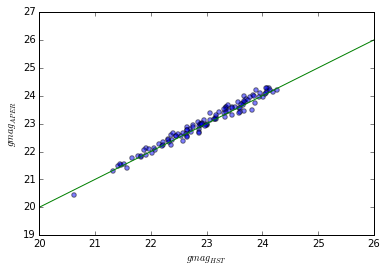

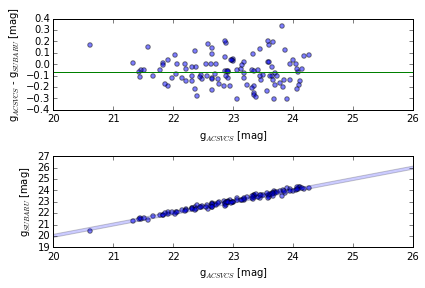

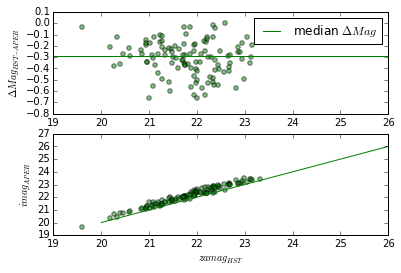

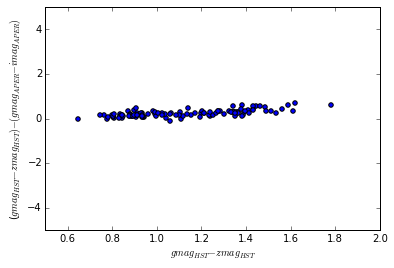

In [28]:
plt.figure()

plt.scatter(N4526['gamag'],N4526[Gmag], alpha = 0.5, c='b')
plt.plot(mock_points,mock_points, c='g')
plt.xlabel('$gmag_{HST}$')
plt.ylabel('$gmag_{APER}$')
plt.xlim(20,26)
plt.legend()


#plt.savefig(filename[:-5]+'_G_zeropints.png')

plt.figure()

plt.subplot(211)
#plt.title('GCs not found in R band')
plt.scatter(N4526['gamag'],mag_offset_g, alpha = 0.5)
plt.axhline(np.median(mag_offset_g) , c='g')
plt.xlabel('g$_{ACSVCS}$ [mag]', size =10)
plt.ylabel('g$_{ACSVCS}$ - g$_{SUBARU}$ [mag]', size=10)
plt.xlim(20,26)
plt.legend()



plt.subplot(212)
plt.scatter(N4526['gamag'],N4526[Gmag], c='b', alpha=0.5)
#plt.title('GCs not found in R band')
#plt.scatter(N4526['gamag'][selection_comp],N4526[Gmag][selection_comp],c='b', alpha = 0.5)

#plt.plot(mock_points,mock_points, c='g')
plt.xlabel('g$_{ACSVCS}$ [mag]', size =10)
plt.ylabel('g$_{SUBARU}$ [mag]', size = 10 )
plt.xlim(20,26)
plt.legend()
plt.fill_between(mock_points,mock_points-rms_offset_g,mock_points+rms_offset_g, interpolate= True , alpha = 0.2)
plt.tight_layout()
plt.savefig(filename[:-5]+'_Gband_offset.png')

plt.figure()

plt.subplot(211)
#plt.title('GCs not found in R band')
plt.scatter(N4526['zamag'],N4526['zamag']-N4526[Imag], alpha = 0.5, c='g')
#plt.scatter(N4526['zamag'][selection_comp],N4526['zamag'][selection_comp]-N4526[Imag][selection_comp], alpha = 0.5, c='r')
plt.axhline(np.median(N4526['zamag']-N4526[Imag]), label='median $\Delta Mag$', c='g')
plt.xlabel('$zmag_{HST}$')
plt.ylabel('$\Delta Mag_{HST-APER}$')
plt.xlim(19,26)
plt.legend()

plt.subplot(212)

#plt.title('GCs not found in R band')
plt.scatter(N4526['zamag'],N4526[Imag], alpha = 0.5, c='g')
#plt.scatter(N4526['zamag'][selection_comp],N4526[Imag][selection_comp], alpha = 0.5, c='r')
plt.plot(mock_points,mock_points, c='g')
plt.xlabel('$zamag_{HST}$')
plt.ylabel('$imag_{APER}$')
#plt.fill_between(mock_points,mock_points-rms_offset_i,mock_points+rms_offset_i, interpolate= True , alpha = 0.2)
plt.xlim(19,26)
#plt.ylim(18,26)
plt.savefig(filename[:-5]+'_Iband_offset.png')


plt.figure()

plt.scatter(N4526['gmag']-N4526['zmag'],(N4526['gmag']-N4526['zmag'])-(N4526[Gmag]-N4526[Imag]))
#plt.errorbar(G_Z_HST,subtract(G_Z_HST,G_I_APER),yerr=(ERR_G+ERR_i+ERR_g+ERR_z),xerr=(ERR_g+ERR_z),fmt= 'none')
plt.ylabel('($gmag_{HST}-zmag_{HST})-(gmag_{APER}-imag_{APER})$')
plt.xlabel('$gmag_{HST}-zmag_{HST}$')
plt.xlim(0.5,2)
plt.ylim(-5,5)
plt.savefig(filename[:-5]+'_g-z_g-i.png')


plt.show()

In [29]:
reds=RV['col6']>0.9
blues=RV['col6']<=0.9

plt.figure()

plt.scatter(RV['col6'],RV['col5'], c=RV['RV'], cmap='seismic')
plt.xlabel('g - i')
plt.colorbar()
plt.ylabel('I [mag]')
plt.savefig(filename[:-5]+'RVvsI.png')

plt.figure()
plt.hist(RV['RV'], bins=15)
plt.xlabel('Radial velocities')
#plt.savefig(filename[:-5]+'RVhist.png')

plt.figure()
plt.hist(RV['col6'], bins=15)
plt.xlabel('g - i')
#plt.savefig(filename[:-5]+'RVhist.png')

plt.figure()
plt.scatter(Dist_RV[RV['col6']>0.9],RV['RV'][RV['col6']>0.9], c='r')
plt.scatter(Dist_RV[RV['col6']<=0.9],RV['RV'][RV['col6']<=0.9], c='b')
plt.ylabel('Radial velocities')
plt.xlabel('Galactocentric Distance')
plt.savefig(filename[:-5]+'RVvsRad.png')

plt.figure()
plt.subplot(211)
plt.scatter(Dist_RV[RV['col6']>0.9],RV['RV'][RV['col6']>0.9], c='r')
#plt.scatter(Dist_RV[RV['col6']<=0.9],RV['RV'][RV['col6']<=0.9], c='b')
plt.ylabel('Radial velocities')
plt.xlabel('Galactocentric Distance')
plt.subplot(212)
plt.scatter(Dist_RV[RV['col6']<=0.9],RV['RV'][RV['col6']<=0.9], c='b')
plt.ylabel('Radial velocities')
plt.xlabel('Galactocentric Distance')

plt.savefig('RV_Gdist.png')

plt.figure()
plt.scatter(Dist_RV,RV['col6'], c=RV['RV'], cmap='rainbow')
#plt.scatter(Dist_RV[RV['col6']<=0.9],RV['RV'][RV['col6']<=0.9], c='b')
plt.ylabel('g -i')
plt.xlabel('Galactocentric Distance')
plt.colorbar()





plt.figure()
plt.scatter(Dist_RV,RV['RV'], c=RV['col6'], cmap='seismic')
plt.scatter(Dist_HST_RV,HST_RV['RV'], c=g_i, cmap='seismic', marker='d')
#plt.scatter(Dist_RV[RV['col6']<=0.9],RV['RV'][RV['col6']<=0.9], c='b')
plt.ylabel('Radial velocity [km/s]')
plt.xlabel('Galactocentric Radius [arcsec]')
#plt.colorbar()

plt.savefig('RV_Gdist2.png')

plt.figure(figsize=(8,5))
a=RV['RV'][reds]
b=RV['RV'][blues]
print RV_DEC[blues], b

plt.scatter(RV_RA[blues],RV_DEC[blues], c=b, cmap='rainbow', marker='d', label='blue GCs')
plt.colorbar()
plt.scatter(RV_RA[reds],RV_DEC[reds], c=a, cmap='rainbow', marker='o',label='red GCs')
plt.xlim(-0.1,0.1)
plt.scatter(0,0, marker='*', c='black', s=40, label= 'Galaxy center')
plt.ylim(-0.1,0.1)

plt.xlabel('$\Delta$ RA', size=15)
plt.ylabel('$\Delta$ DEC', size=15)
plt.legend(scatterpoints=1)
plt.savefig('RV_complete.png')
plt.show()

KeyError: "Key 'col6' does not exist."

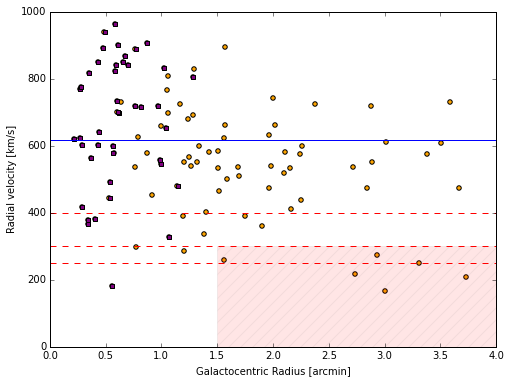

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(GDist_RV[GDist_RV>min(GDist_RV)]/60.,RV['RV'][GDist_RV>min(GDist_RV)], c='orange')
#plt.colorbar()
plt.scatter(GDist_HST_RV/60.,HST_RV['RV'], c='purple', marker='s')
#plt.scatter(Dist_RV[RV['col6']<=0.9],RV['RV'][RV['col6']<=0.9], c='b')
plt.ylabel('Radial velocity [km/s]')
plt.xlabel('Galactocentric Radius [arcmin]')
plt.axhline(617, ls='-')
plt.axhline(400, ls='--', c='r')
plt.axhline(300, ls='--',c='r')
plt.axhline(250, ls='--',c='r')
plt.xlim(0,4)
plt.ylim(0,1000)
plt.fill([1.5,4,4,1.5],[0,0,300,300], color='red',alpha=0.1, edgecolor='grey', hatch='//')
#plt.colorbar()

plt.savefig('RV_Gdist2.png')

In [74]:
print np.median(RV['RV'][(GDist_RV>min(GDist_RV))&(GDist_RV/60.>=1.5)&(RV['RV']<=300)]), '\n'
print np.median(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']<=300)])

233.5 

250.0


In [75]:
# make file 

#ascii.write(N4526[(N4526['RV']>=400)&()])
#len(N4526[(RV['RV']>=300)&(GDist_RV<=150)])
print 'full'
print 'mean',np.mean(RV['RV'][GDist_RV>min(GDist_RV)])
print 'variance', np.var(RV['RV'][GDist_RV>min(GDist_RV)]), '\n'

print 'corner'
print 'mean',np.mean(RV['RV'][(GDist_RV>min(GDist_RV))&(GDist_RV/60.<=1.5)&(RV['RV']>=300)])
print 'variance', np.var(RV['RV'][(GDist_RV>min(GDist_RV))&(GDist_RV/60.<=1.5)&(RV['RV']>=300)]), '\n'

print '250'
print 'mean',np.mean(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']>=250)])
print 'variance', np.var(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']>=250)]), '\n'

print '300'
print 'mean',np.mean(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']>=300)])
print 'variance', np.var(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']>=300)]), '\n'

print '400'
print 'mean',np.mean(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']>=400)])
print 'variance', np.var(RV['RV'][(GDist_RV>min(GDist_RV))&(RV['RV']>=400)]), '\n'

full
mean 594.226
variance 33761.3 

corner
mean 657.234
variance 27082.5 

250
mean 609.951
variance 28516.1 

300
mean 627.299
variance 23831.2 

400
mean 650.674
variance 19304.8 



In [10]:
#HST=N4526
SHST= HST['zamag'][HST['VCC']==1535 ]
SHST_G= HST['gamag'][HST['VCC']==1535 ]
Sel_HST=(HST['VCC']==1535)

D_RA=N4526['new_RA']-188.51262
D_DEC=N4526['new_Dec']-7.6991162

D_HST_RA=HST['new_RA'][HST['VCC']==1535 ]-188.51262
D_HST_DEC=HST['new_Dec'][HST['VCC']==1535 ]-7.6991162

imag = N4526['zamag']+0.554*(N4526['gamag']-N4526['zamag'])-0.542


GDist= ((D_RA**2+D_DEC**2)**0.5)*(60**2)
GDist_HST= ((D_HST_RA**2+D_HST_DEC**2)**0.5)*(60**2)

In [11]:
Bins= [20.5,21,21.5,22,22.5,23,24,25]
Bins_G= [21.5,22,22.5,23,23.5,24,24.5,25]

HST_binned= np.digitize(SHST[GDist_HST>60], Bins)
SSEX_binned= np.digitize(N4526['zamag'][GDist>60],Bins)

HST_G_binned= np.digitize(SHST_G[GDist_HST>60], Bins_G)
SSEX_G_binned= np.digitize(N4526['gamag'][GDist>60],Bins_G)

SSEX_R_binned= np.digitize(N4526['gamag'][GDist>60],Bins_G)



In [12]:
HST_B = np.bincount(HST_binned)
SSEX_B = np.bincount(SSEX_binned)



if (len(HST_B)>len(SSEX_B)):
    SSEX_B=np.insert(SSEX_B,len(SSEX_B),0)
    if (len(HST_B)>len(SSEX_B)):
        SSEX_B=np.insert(SSEX_B,len(SSEX_B),0)
else:
    print 'has the right shape'

    
    
    
HST_G_B = np.bincount(HST_G_binned)
SSEX_G_B = np.bincount(SSEX_G_binned)

SSEX_R_B = np.bincount(SSEX_R_binned)




if (len(HST_G_B)>len(SSEX_G_B)):
    SSEX_G_B=np.insert(SSEX_G_B,len(SSEX_G_B),0)
    if (len(HST_G_B)>len(SSEX_G_B)):
        SSEX_G_B=np.insert(SSEX_G_B,len(SSEX_G_B),0)
else:
    print 'should be the right length \n\n'

if (len(HST_G_B)>len(SSEX_R_B)):
    SSEX_R_B=np.insert(SSEX_R_B,len(SSEX_R_B),0)
    if (len(HST_G_B)>len(SSEX_R_B)):
        SSEX_R_B=np.insert(SSEX_R_B,len(SSEX_R_B),0)
else:
    print 'should be the right length \n\n'



print 'HST objects:',HST_B
print 'I band SUBARU',SSEX_B
print ' \n'
print 'HST objects:',HST_G_B
print 'G band SUBARU',SSEX_G_B
print ' \n'
print 'HST objects:',HST_G_B
print 'R band SUBARU',SSEX_R_B

HST objects: [ 4  6  9 15 14 12 34 13]
I band SUBARU [ 4  6  9 14 11  7  5  0]
 

HST objects: [ 3  7  7 13  8 19 18 14 18]
G band SUBARU [ 3  7  7 12  6 13  8  0  0]
 

HST objects: [ 3  7  7 13  8 19 18 14 18]
R band SUBARU [ 3  7  7 12  6 13  8  0  0]


In [13]:
completeness_frac=np.true_divide(SSEX_B,HST_B)

if len(Bins)<len(completeness_frac):
    Bins=np.insert(Bins,0,min(SHST))
    
if len(Bins)>len(completeness_frac):
    completeness_frac=np.insert(completeness_frac,len(completeness_frac),0)
    
completeness_frac_G=np.true_divide(SSEX_G_B,HST_G_B)

if len(Bins_G)<len(completeness_frac_G):
    Bins_G=np.insert(Bins_G,0,min(SHST_G))
    
completeness_frac_R=np.true_divide(SSEX_R_B,HST_G_B)

if len(Bins_G)<len(completeness_frac_R):
    Bins_G=np.insert(Bins_G,0,min(SHST_R))

[ 0.5         0.40824829  0.33333333  0.24944383  0.23690177  0.22047928
  0.06576671  0.        ]


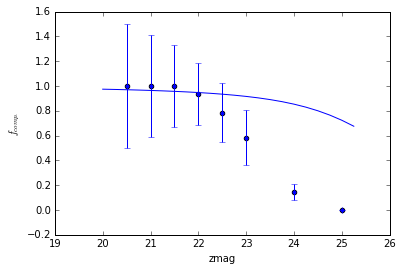

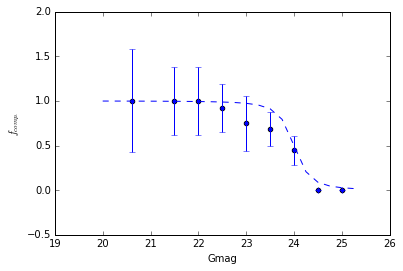

In [14]:
def Pritchet_f (mag, mag_0, a ):
    f=0.5 *(1-(a*(mag-mag_0))/(1+(a**2)*(mag-mag_0)**2)**0.5)
    
    return f
fake= np.arange(20,25.5,0.25)
print np.true_divide(np.sqrt(SSEX_B),HST_B)


np.true_divide(np.sqrt(SSEX_G_B),HST_G_B)

plt.figure()

plt.scatter(Bins, completeness_frac)
plt.errorbar(Bins, completeness_frac, xerr=0,yerr=np.true_divide(np.sqrt(SSEX_B),HST_B),color='b',fmt='.')
plt.xlabel('zmag')
plt.ylabel('$f_{comp.}$')
#plt.ylim(0.4,1.1)
plt.plot(fake,Pritchet_f(fake,26,0.5))
plt.savefig(filename[:-5]+'_Mag_completeness_I.png')


plt.figure()

plt.scatter(Bins_G, completeness_frac_G)
plt.plot(fake,Pritchet_f(fake,24,2.9), linestyle = '--')
plt.errorbar(Bins_G, completeness_frac_G, xerr=0,yerr=np.true_divide(np.sqrt(SSEX_G_B),HST_G_B),color='b',fmt='.')
plt.xlabel('Gmag')
plt.ylabel('$f_{comp.}$')
plt.savefig(filename[:-5]+'_Mag_completeness_G.png')
#plt.figure()
#plt.hist(completeness_frac)


plt.show()

# Completeness with galactocentric radius 
using only sources out to 21st mag (may need minor completeness correction)
apply completeness correction for any large range of magnitudes as at 22

In [15]:
D_RA=N4526['new_RA'][(N4526['gamag']<=22.5)]-188.51262
D_DEC=N4526['new_Dec'][(N4526['gamag']<=22.5)]-7.6991162

D_HST_RA=HST['new_RA'][Sel_HST&(HST['gamag']<=22.5)]-188.51262
D_HST_DEC=HST['new_Dec'][Sel_HST& (HST['gamag']<=22.5)]-7.6991162



GDist= ((D_RA**2+D_DEC**2)**0.5)*(60**2)
GDist_HST= ((D_HST_RA**2+D_HST_DEC**2)**0.5)*(60**2)

Bins_Dist= [20,30,40,50,60,70,80,100,120]

HST_DB= np.digitize(GDist_HST, Bins_Dist)
SSEX_DB= np.digitize(GDist,Bins_Dist)

HST_Dist = np.bincount(HST_DB)
SSEX_Dist = np.bincount(SSEX_DB)



if (len(HST_Dist)>len(SSEX_Dist)):
    SSEX_Dist=np.insert(SSEX_Dist,len(SSEX_Dist),0)
if len(HST_Dist)<len(SSEX_Dist):
    HST_Dist=np.insert(HST_Dist,len(HST_Dist),0)
else:
    print 'has the right shape'


print HST_Dist
print SSEX_Dist

completeness_frac_Dist=np.true_divide(SSEX_Dist+0.0001,HST_Dist+0.0001)

print len (Bins_Dist), len(completeness_frac_Dist)

if len(Bins_Dist)<len(completeness_frac_Dist):
    Bins_Dist=np.insert(Bins_Dist,len(Bins_Dist),max(Bins_Dist)-Bins_Dist[1]+Bins_Dist[2])
if len(Bins_Dist)>len(completeness_frac_Dist):
    print 'help'



has the right shape
[3 2 3 5 7 3 4 2 5 3]
[0 1 3 4 7 3 4 2 5 3]
9 10


130


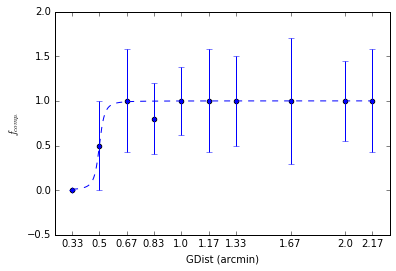

In [16]:
plt.figure()
fake2= np.arange(20,max(Bins_Dist),0.001)
plt.plot((fake2),Pritchet_f(fake2,30,-0.5), linestyle = '--')
print max(Bins_Dist)

plt.scatter(Bins_Dist, completeness_frac_Dist)
plt.xticks(Bins_Dist,np.round(np.true_divide(Bins_Dist,60),2))
plt.errorbar(Bins_Dist, completeness_frac_Dist, xerr=0,yerr=np.true_divide(np.sqrt(SSEX_Dist),HST_Dist),color='b',fmt='.')
plt.xlabel('GDist (arcmin)')
plt.ylabel('$f_{comp.}$')
plt.savefig(filename[:-5]+'_GDist_completeness.png')
plt.show()

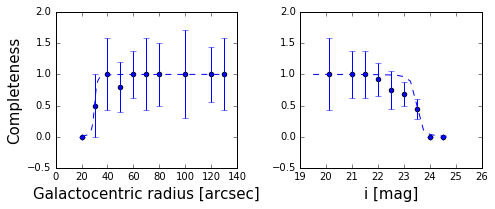

In [17]:
plt.figure(figsize=(7,3))
plt.subplot(122)
Bins_i = Bins_G-0.5
plt.scatter(Bins_i, completeness_frac_G)
plt.plot(fake-0.5,Pritchet_f(fake-0.5,24-0.5,5), linestyle = '--')
plt.errorbar(Bins_i, completeness_frac_G, xerr=0,yerr=np.true_divide(np.sqrt(SSEX_G_B),HST_G_B),color='b',fmt='.')
plt.xlabel('i [mag]',size=15)
#plt.ylabel('$f_{comp.}$')
#plt.savefig(filename[:-5]+'_Mag_completeness_G.png')

#Bins_new =Bins_Dist/60
plt.subplot(121)
plt.scatter(Bins_Dist, completeness_frac_Dist)
plt.plot((fake2),Pritchet_f(fake2,30,-0.5), linestyle = '--')
#plt.xticks(Bins_Dist,np.round(np.true_divide(Bins_Dist,60),2))
plt.errorbar(Bins_Dist, completeness_frac_Dist, xerr=0,yerr=np.true_divide(np.sqrt(SSEX_Dist),HST_Dist),color='b',fmt='.')
plt.xlabel('Galactocentric radius [arcsec]', size=15)
#plt.ylim(-0.5,2.5)
#plt.xticks(Bins_Dist,np.round(np.true_divide(Bins_Dist,60),2))
plt.ylabel('Completeness', size=15)
plt.tight_layout()
plt.savefig('HST_comp.png')
plt.show()